在不同数据集上实现ADVI算法。ADVI的模型构建和训练测试在“ADVI_bnn.py”实现

In [1]:
import os
import numpy as np
import pickle
from scipy import stats
import matplotlib.pyplot as plt

from dataset.UCIdataset import UCIDataset
from ADVI_bnn import train, test, construct_nn

这里先定义两个显示测试结果的函数，分布得到模型在测试集上的log-likelihood和ELBO随迭代次数的变化

In [2]:
def log_prob(ppc, Y_test):
    pred = ppc['out']
    sd = np.std(ppc['out'], axis=0)
    logp = [np.mean(stats.norm.logpdf(pred[:, i] - Y_test[i],
                                      loc=0, scale=sd[i])) for i in range(len(sd))]
    print ('log-likelihood mean: %.2f'%np.mean(logp))
    print('log-likelihood std: %.3f' % np.std(logp))
    return np.mean(logp), np.std(logp)


def show_inference(inference, b=0, e=100):
    plt.plot(-inference.hist[b:e], alpha=.3)
    plt.ylabel('ELBO')
    plt.xlabel('iteration')
    plt.show()
    return None

打包训练和测试的函数

In [3]:
def run(dataset_name, root_path, hypers, shape='train_test'):
    np.random.seed(123)

    for time in range(hypers['times']):
        outpath = os.path.join(root_path, str(time))
        if not os.path.exists(outpath):
            os.makedirs(outpath)
        if dataset_name == 'face':
            data = FaceDataset("./dataset", 0.9)
        else:
            data = UCIDataset(dataset_name, 0.9)

        X = np.append(data.Xtrain, data.Xtest, axis=0)
        Y = np.append(data.Ytrain, data.Ytest)
        data.Ytrain = data.Ytrain.reshape(len(data.Ytrain), )
        data.Ytest = data.Ytest.reshape(len(data.Ytest), )
        neural_network = construct_nn(
            X, Y, data.Xtrain, data.Ytrain, hypers)

        approx_file = os.path.join(outpath, "approx.pkl")
        inference_file = os.path.join(outpath, "inference.pkl")
        ppc_file = os.path.join(outpath, "ppc.pkl")
        if shape == 'train_test':
            inference, approx = train(
                neural_network, inference_file, approx_file, hypers)
            ppc = test(
                neural_network,
                approx,
                data.Xtest,
                data.Ytest,
                ppc_file,
                trace_samples=hypers['pred_samples'],
                pred_samples=hypers['pred_samples'])
        if shape == 'test':
            with open(inference_file, 'rb') as f:
                inference = pickle.load(f)
            with open(approx_file, 'rb') as f:
                approx = pickle.load(f)

            ppc = test(
                neural_network,
                approx,
                data.Xtest,
                data.Ytest,
                ppc_file,
                trace_samples=hypers['pred_samples'],
                pred_samples=hypers['pred_samples'])
        if shape == 'show':
            with open(inference_file, 'rb') as f:
                inference = pickle.load(f)
            with open(approx_file, 'rb') as f:
                approx = pickle.load(f)
            with open(ppc_file, 'rb') as f:
                ppc = pickle.load(f)

        show_inference(inference, b=0, e=hypers['n_sample'])
        log_prob(ppc, data.Ytest)

    return None

开始训练模型并给出测试集上的相关结果，这里以“conc”数据集为例。

Average Loss = 3,725.6: 100%|██████████| 100000/100000 [02:19<00:00, 718.67it/s] 
Finished [100%]: Average Loss = 3,725.5
100%|██████████| 5000/5000 [00:46<00:00, 106.91it/s]


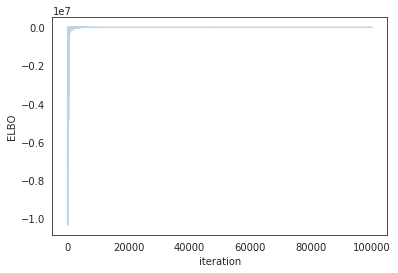

log-likelihood mean: -4.14
log-likelihood std: 0.558


In [4]:
dataset_name = "conc" #数据集名称
root_path = os.path.join('/home/yunnd/project/ADVI_result_test', dataset_name) #存储结果的路径
hypers = {'conc': {'sd': 1,
                   'lr': 0.01,
                   'n_hidden': 50,
                   'n_sample': 100000,
                   'pred_samples': 5000,
                   'times': 1
                   },
          'powe': {'sd': 1,
                   'lr': 0.01,
                   'n_hidden': 50,
                   'n_sample': 100000,
                   'pred_samples': 5000,
                   'times': 1
                   },
          'yach': {'sd': 1,
                   'lr': 0.01,
                   'n_hidden': 50,
                   'n_sample': 100000,
                   'pred_samples': 5000,
                   'times': 1
                   },
          'prot': {'sd': 1,
                   'lr': 0.01,
                   'n_hidden': 50,
                   'n_sample': 100000,
                   'pred_samples': 5000,
                   'times': 1
                   },
          'face':
                 {'in': {"scale": [[1.0]], "shift": [[0.0]]},
                  'out': {"scale": [[1.0, 0.1]], "shift": [[0.0, -1.0]]},
                  'hidden_dims': [50],
                  'learning_rate': 0.3,
                  'n_epochs': 800,
                  'epochs': [225, 400]
                  }
          }
run(dataset_name, root_path, hypers[dataset_name], 'train_test')